In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.io import BlackrockIO
from nilearn import datasets, plotting

In [2]:
patient = 12

### create chanID file, which will be used for QC

In [3]:
df_rows = []
# to get channel & unit IDs
fig_files = glob.glob(f'../../results/2025{patient}/osort_mat/figs/5/*')

for fig_file in sorted(fig_files):

    # skip raw fig files, and all-unit fig files
    if 'CL' not in fig_file or 'ALL' in fig_file: continue
    
    chanID = int(os.path.basename(fig_file).split('_')[0][1:])
    unitID = int(os.path.basename(fig_file).split('_')[2])
    df_rows.append((chanID, unitID))

# sort properly by channel then unit
df_rows_sorted = sorted(df_rows, key=lambda x: (x[0], x[1]))
    
chanID_df = pd.DataFrame(df_rows_sorted, columns=['chanID', 'unitID'])
chanID_df.to_csv(f'../../results/2025{patient}/records/chanID_pt{patient}.csv', index=False)
chanID_df

,chanID,unitID
0,97,596
1,97,612
2,98,1432
3,98,1502
4,98,1543
...,...,...
85,126,156
86,127,182
87,127,188
88,128,167


### perform manual QC. then load:

In [4]:
QC_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')

# clean
QC_df['keep'] = QC_df['keep'].fillna(0)
dropped_clustIDs = QC_df[QC_df['keep'] != 1]['unitID'].astype(int).tolist()
dropped_clustIDs.extend([0, 1, 99999999])
QC_df = QC_df[~QC_df['unitID'].isin(dropped_clustIDs)].copy().reset_index(drop=True)

QC_df

,chanID,unitID,keep,notes
0,97,612,1.0,isolation
1,98,1583,1.0,NaN
2,99,703,1.0,NaN
3,100,683,1.0,isolation
4,101,952,1.0,NaN
5,102,2460,1.0,NaN
6,102,2475,1.0,isolation
7,102,2477,1.0,NaN
8,103,1466,1.0,isolation
9,104,2349,1.0,isolation


In [5]:
def getclustID2spikes(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    dropped_clustIDs.extend([0, 1, 99999999])  # also drop these
    clust2spikes = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in clust2spikes: clust2spikes[clustID] = [] # init

        clust2spikes[clustID].append(spike)

    return clust2spikes

### create initial df with chanID, clustID, spikes, #spikes, avgFR
 

In [6]:
samp_rate = 1000000
neur_spikes_df = []

# go through OSort mat files
for mat_file in glob.glob(f'../../results/2025{patient}/osort_mat/sort/5/*_sorted_new.mat'):

    chan_mat = sio.loadmat(mat_file)

    chanID = int(os.path.basename(mat_file).split('_')[0][1:])  # A198_sorted_new.mat -> 198
    clustIDs = chan_mat['assignedNegative'][0] # len = total n_spikes
    spikes = chan_mat['newTimestampsNegative'][0] # len = total n_spikes
    # clust_spikes_df = pd.DataFrame({'clustID': clustIDs, 'spike': spikes})

    # create dict:  clustID => [spikes], retaining only QCed units
    clust2spikes = getclustID2spikes(clustIDs, spikes) # len = # unique QCed clustIDs

    # 1 row per QCed clustID
    clust_df = pd.DataFrame([
        {
            "chanID": chanID,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in clust2spikes.items()
    ])
    neur_spikes_df.append(clust_df)

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)
# sort by chanID and then clustID
neur_spikes_df = neur_spikes_df.sort_values(by=['chanID', 'clustID']).reset_index(drop=True)
neur_spikes_df


,chanID,clustID,spikes,#spikes,avgFR
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847


In [7]:
# print lens of clustIDs in both dfs
print(f'len QC_df clustIDs: {len(QC_df["unitID"].unique())}')
print(f'len neur_spikes_df clustIDs: {len(neur_spikes_df["clustID"].unique())}')

# instead, for every channel, print clustIDs that are in QC_df but not in neur_spikes_df
for chanID in QC_df['chanID'].unique():
    qc_clustIDs = set(QC_df[QC_df['chanID'] == chanID]['unitID'])
    neur_clustIDs = set(neur_spikes_df[neur_spikes_df['chanID'] == chanID]['clustID'])
    missing_clustIDs = qc_clustIDs - neur_clustIDs
    if missing_clustIDs:
        print(f'chanID {chanID} missing clustIDs: {missing_clustIDs}')

len QC_df clustIDs: 33
len neur_spikes_df clustIDs: 33


### channel -> region -> index -> coordinates (-> atlas regions?)

In [8]:
# channels -> regions
channelInfo = sio.loadmat(f'../../results/2025{patient}/records/2025{patient}_DI_ChannelMap.mat')

if patient == 12: channelMap = channelInfo['ChannelMap1'].flatten()
elif patient == 18: channelMap = channelInfo['ChannelMap2'].flatten()

labelMap = channelInfo['LabelMap'].flatten() # contains region labels
labelMap = np.array([str(label.squeeze()) for label in labelMap])  # convert to str

# dict after removing nan keys
nan_mask = ~np.isnan(channelMap)
channel2label = dict(zip(channelMap[nan_mask], labelMap[nan_mask]))

neur_spikes_df['region'] = neur_spikes_df['chanID'].map(channel2label).fillna(neur_spikes_df['chanID']).apply(lambda x: str(x))
print(neur_spikes_df['region'].unique())


['mLOFC1' 'mLOFC2' 'mLOFC3' 'mLOFC4' 'mLOFC5' 'mLOFC6' 'mLOFC7' 'mLOFC8'
 'mLACC1' 'mLACC2' 'mLACC3' 'mLACC4' 'mLACC5' 'mLACC6' 'mLACC7' 'mLACC8'
 'mRHIP1' 'mRHIP2' 'mRHIP3' 'mRHIP4' 'mRHIP5' 'mRHIP6' 'mRHIP8']


In [9]:
# regions -> coords

def clean_entry(x):
    while isinstance(x, (np.ndarray, list)):
        x = x[0]
    if isinstance(x, (bytes, bytearray)):
        x = x.decode("utf-8", errors="ignore")
    return str(x)

# load
electrodeInfo = sio.loadmat(f'../../results/2025{patient}/records/2025{patient}_DI_Electrodes.mat')
ElecMapRaw   = pd.DataFrame(electrodeInfo['ElecMapRaw']) # region -> ID
ElecXYZRaw   = pd.DataFrame(electrodeInfo['ElecXYZRaw']) # ID -> coordinates
ElecAtlasRaw = pd.DataFrame(electrodeInfo['ElecAtlasRaw']) # atlas coords?

atlas_index = 0 # NMM

# clean
region_s = ElecMapRaw[0].apply(clean_entry)                    # Series of regions
atlas_s  = ElecAtlasRaw.iloc[:, atlas_index].apply(clean_entry)  # Series of atlas regions

# build small tables
region2id_df = pd.DataFrame({"region": region_s.values,
                             "ID": np.arange(len(region_s))})
id2xyz_df = ElecXYZRaw.reset_index().rename(columns={'index':'ID', 0:'x', 1:'y', 2:'z'})
# xyz2atlasRegions = pd.DataFrame({"ID": np.arange(len(atlas_s)),
#                                  "atlas_region": atlas_s.values})

# merge
final_neur_df = (neur_spikes_df
                .merge(region2id_df, on='region', how='left')
                .merge(id2xyz_df, on='ID', how='left')
                # .merge(xyz2atlasRegions, on='ID', how='left')
                )
final_neur_df = final_neur_df.drop(columns=['ID'])
final_neur_df.to_csv(f'../../results/2025{patient}/records/df_spikes.csv', index=False)


### inspect

In [10]:
eg_spikes = final_neur_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
n_neurs = len(final_neur_df)
final_neur_df

last 5 spikes (s): [1599.64183333 1600.6705     1600.95396667 1601.53736667 1601.88753333]
last 5 spikes (min): [26.66069722 26.67784167 26.68256611 26.69228944 26.69812556]


,chanID,clustID,spikes,#spikes,avgFR,region,x,y,z
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538,mLOFC1,-0.111605,40.172309,-15.682235
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,mLOFC2,-0.111605,42.570655,-15.682235
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458,mLOFC3,-0.111605,41.371482,-15.682235
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937,mLOFC4,-1.311382,40.172309,-15.682235
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,mLOFC5,-1.311382,42.570655,-15.682235
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,mLOFC6,-2.511159,42.570655,-15.682235
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,mLOFC6,-2.511159,42.570655,-15.682235
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,mLOFC6,-2.511159,42.570655,-15.682235
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,mLOFC7,-2.511159,40.172309,-15.682235
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,mLOFC8,-2.511159,41.371482,-15.682235


### plot electrode location

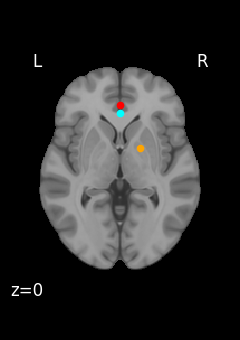

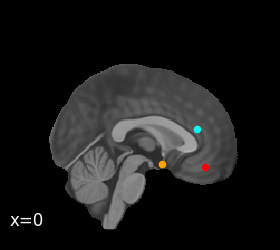

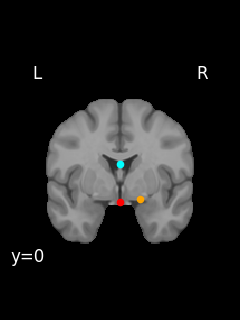

{'OFC': 'red', 'ACC': 'cyan', 'HIP': 'orange'}


In [11]:
template = datasets.load_mni152_template()

# grab most distal channels for each electrode
# IDs were different for older recording system (pt12)
if patient == 12: plot_chanIDs = [97, 105, 113]
else: plot_chanIDs = [193, 202, 210]

coords_list = []
for ch in plot_chanIDs:
    row = final_neur_df[final_neur_df['chanID'] == ch].iloc[0]   # first match
    coords_list.append([row.x, row.y, row.z])

coords = np.array(coords_list)

coord_regions  = ['OFC', 'ACC', 'HIP']
colors = {'OFC':'red', 'ACC':'cyan', 'HIP':'orange'}
marker_size = 20
# x = sagittal, y = coronal, z = axial

# 1. axial
# fix z (axial)
axial_cut = 0
coords_ax = coords.copy()
coords_ax[:,2] = axial_cut
disp1 = plotting.plot_anat(template, display_mode='z', cut_coords=[axial_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_ax, coord_regions):
    disp1.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])
    
# 2. sagittal (x=0)
sag1_cut = 0
coords_sag1 = coords.copy()
coords_sag1[:,0] = sag1_cut
disp2 = plotting.plot_anat(template, display_mode='x', cut_coords=[sag1_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_sag1, coord_regions):
    disp2.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# 3. coronal (y=30)
cor_cut = 0
coords_cor = coords.copy()
coords_cor[:,1] = cor_cut
disp4 = plotting.plot_anat(template, display_mode='y', cut_coords=[cor_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_cor, coord_regions):
    disp4.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

plotting.show()

print(colors)

### First, get df_spikes (neur & spike times), df_trigs (event times), and df_psychopy (trial info)

### df_spikes

In [12]:
df_spikes = final_neur_df.copy()

eg_spikes = df_spikes['spikes'].iloc[0]
print("last 5 spikes (s):", eg_spikes[-5:])
print("last 5 spikes (min):", eg_spikes[-5:] / 60)

n_neurs = len(df_spikes)
df_spikes


last 5 spikes (s): [1599.64183333 1600.6705     1600.95396667 1601.53736667 1601.88753333]
last 5 spikes (min): [26.66069722 26.67784167 26.68256611 26.69228944 26.69812556]


,chanID,clustID,spikes,#spikes,avgFR,region,x,y,z
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538,mLOFC1,-0.111605,40.172309,-15.682235
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,mLOFC2,-0.111605,42.570655,-15.682235
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458,mLOFC3,-0.111605,41.371482,-15.682235
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937,mLOFC4,-1.311382,40.172309,-15.682235
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,mLOFC5,-1.311382,42.570655,-15.682235
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,mLOFC6,-2.511159,42.570655,-15.682235
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,mLOFC6,-2.511159,42.570655,-15.682235
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,mLOFC6,-2.511159,42.570655,-15.682235
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,mLOFC7,-2.511159,40.172309,-15.682235
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,mLOFC8,-2.511159,41.371482,-15.682235


### df_trigs

In [13]:
# load

nev_file = glob.glob(f'../../results/2025{patient}/raw/*.nev')[0]
io = BlackrockIO(nev_file)
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs_raw = pd.DataFrame({
    "trigger": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs_raw["event"] = df_trigs_raw["trigger"].map(code_map)

df_trigs = df_trigs_raw[3:]
print(df_trigs.head(15))


    trigger       time                 event
3        10  36.379967         block started
4        20  70.978933      baseline started
5        30  71.864133          stim started
6        40  72.858367         delay started
7        50  74.342867          task started
8        51  75.375000          marker moved
9        52  75.375133          left pressed
10       53  75.974967         left released
11       56  76.374967    response submitted
12       60  76.375833  anticipation started
13       70  76.624967      feedback started
14       20  77.625233      baseline started
15       30  78.609500          stim started
16       40  79.608367         delay started
17       50  81.044033          task started


In [14]:
# checks
n_blocks = sum(df_trigs['event'] == 'block started')
n_stim = sum(df_trigs['event'] == 'stim started')
n_delay = sum(df_trigs['event'] == 'delay started')
n_task = sum(df_trigs['event'] == 'task started')
n_feedback = sum(df_trigs['event'] == 'feedback started')
print(n_blocks, n_stim, n_delay, n_task, n_feedback)


6 240 240 240 240


### df_psychopy

In [15]:
pts_df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_psych = pts_df.loc[pts_df['subj'] == str(patient)].reset_index(drop=True)
df_psych

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,Mcross.started,Mcross.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Unnamed: 122,Unnamed: 115,stim_ranks,resp_ranks
0,1.0,0.0,0.364,-0.0,0.02,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,38.0
1,1.0,0.0,0.352,-0.0,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.5,37.0
2,0.0,0.0,0.284,0.0,0.14,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.5,33.0
3,1.0,0.0,-0.280,-0.0,-0.30,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,9.0
4,1.0,0.0,0.304,-0.0,0.34,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.260,0.2,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,25.0
236,1.0,0.0,0.124,0.2,-0.18,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,15.0
237,1.0,0.0,0.252,0.2,0.38,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5,23.5
238,1.0,0.0,0.320,0.2,0.14,0,1,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.5,37.0


In [16]:
df_psych['uncertainty'].value_counts()
pt_base = df_psych[df_psych['condition'] == 'baseline']
pt_gain_exp = df_psych[df_psych['condition'] == 'rew_comp']
pt_loss_exp = df_psych[df_psych['condition'] == 'pen_comp']
pt_base['uncertainty'].value_counts(), pt_gain_exp['uncertainty'].value_counts(), pt_loss_exp['uncertainty'].value_counts()

(uncertainty
 True     40
 False    40
 Name: count, dtype: int64,
 uncertainty
 True     60
 False    20
 Name: count, dtype: int64,
 uncertainty
 True     60
 False    20
 Name: count, dtype: int64)

## get spikes & rates within each epoch, for every neuron & trial

In [17]:
# bin params
size, dt = .02, .001

# epoch prestarts and durations
epochs = ['baseline', 'stim', 'delay', 'task', 'feedback']
epoch_prestarts, epoch_durs = {}, {}

# plot -.25s before onset for most epochs, -1s for task (response submission), 0 for baseline
for epoch in epochs:
    if epoch == 'baseline':
        epoch_prestarts[epoch] = 0
    elif epoch == 'task':
        epoch_prestarts[epoch] = 1
    else:
        epoch_prestarts[epoch] = .25

# plot duration: 1.5 for delay, and 1s for the others, 0 for task (because we plot till onset=0 of anticipation) 
for epoch in epochs:
    if epoch == 'delay':
        epoch_durs[epoch] = 1.5
    elif epoch == 'task':
        epoch_durs[epoch] = 0
    else:
        epoch_durs[epoch] = 1

def get_normed_FRs(FRs, base_FRs):
    # trial-avged baseline, (neurons, 1)
    # return FRs - base_FRs.mean(axis=(0, 2), keepdims=True)
    # baseline FR per trial, (trials, neurons, 1), i.e.,avg across only timebins (axis=2)
    return FRs - base_FRs.mean(axis=2, keepdims=True)


def get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in epoch window
        df_trigs: trig times 
        df_spikes: spike times per neur '''

    epoch_prestart = epoch_prestarts[epoch]
    epoch_dur = epoch_durs[epoch]

    # bin edges & centers for hists & plots
    bin_edges = np.arange(-epoch_prestart, epoch_dur + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & epoch_dur edges
    n_bins = len(bin_edges) - 1

    # a. get 240 START times of this epoch. then STOPS = STARTS + durations.
    epoch_start_rows = df_trigs[df_trigs['event'] == f'{epoch} started'].index
    epoch_starts = df_trigs.loc[epoch_start_rows, 'time'].values
    assert len(epoch_starts) == 240

    # b. since stop times of responses are variable,
    # get 240 STOP times of response, which is marked by 'anticipation started'. then STARTS = STOPS - durations (1).
    ant_start_rows = df_trigs[df_trigs['event'] == f'anticipation started'].index
    ant_starts = df_trigs.loc[ant_start_rows, 'time'].values
    assert len(ant_starts) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(epoch_starts), len(df_spikes)), dtype=object)
    trial_neur_FRs = np.zeros((len(epoch_starts), len(df_spikes), n_bins))

    # for this particular epoch, grab spikes for each trial & neur 
    for trial_idx in range(len(epoch_starts)):

        for neur_idx, (_, neur_row) in enumerate(df_spikes.iterrows()):

            spike_train = np.zeros(n_bins)

            # 1. spikes within epoch (onset-prestart => onset+duration)

            if epoch != 'task': 
                trial_epoch_spikes = neur_row['spikes'][(neur_row['spikes'] >= epoch_starts[trial_idx] - epoch_prestart) &
                                                        (neur_row['spikes'] <= epoch_starts[trial_idx] + epoch_dur)]          
                trial_epoch_spikes = trial_epoch_spikes - epoch_starts[trial_idx] # align
            
            else: # response
                trial_epoch_spikes = neur_row['spikes'][(neur_row['spikes'] >= ant_starts[trial_idx] - epoch_prestart) &
                                                        (neur_row['spikes'] <= ant_starts[trial_idx] + epoch_dur)]          
                trial_epoch_spikes = trial_epoch_spikes - ant_starts[trial_idx] # align

            # 2. FRs within epoch
            # histogram counts → Hz
            counts, _ = np.histogram(trial_epoch_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)
            # scale FR so 1 spike ≈ 1 Hz peak
            smooth_spike_train = smooth_spike_train / 20.0
            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_epoch_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# baseline spikes/FRs for norming
base_spikes, base_FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, 'baseline')

### plot baseline spikes and FRs for random neuron on random trials

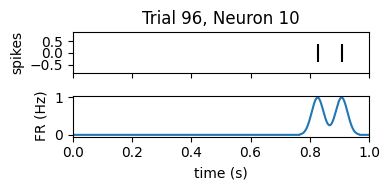

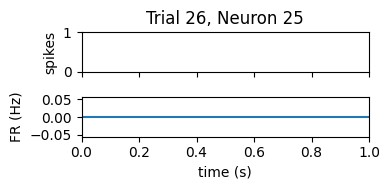

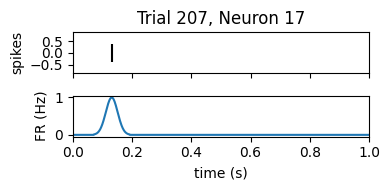

In [18]:
n_trials, n_neurs = base_spikes.shape[:2]

for _ in range(3):
    trial_idx = np.random.randint(0, n_trials)
    neur_idx  = np.random.randint(0, n_neurs)

    spikes = base_spikes[trial_idx, neur_idx]
    fr     = base_FRs[trial_idx, neur_idx]

    fig, ax = plt.subplots(2, 1, figsize=(4,2), sharex=True)

    ax[0].eventplot(spikes, colors='black', lineoffsets=0, linelengths=0.8)
    ax[0].set_ylabel("spikes")
    ax[0].set_title(f"Trial {trial_idx}, Neuron {neur_idx}")

    ax[1].plot(bin_centers, fr)
    ax[1].set_ylabel("FR (Hz)")
    ax[1].set_xlabel("time (s)")
    ax[1].set_xlim(0, 1)   # explicitly enforce 0–1 for baseline

    plt.tight_layout()
    plt.show()


### rasters + psth for all neurons

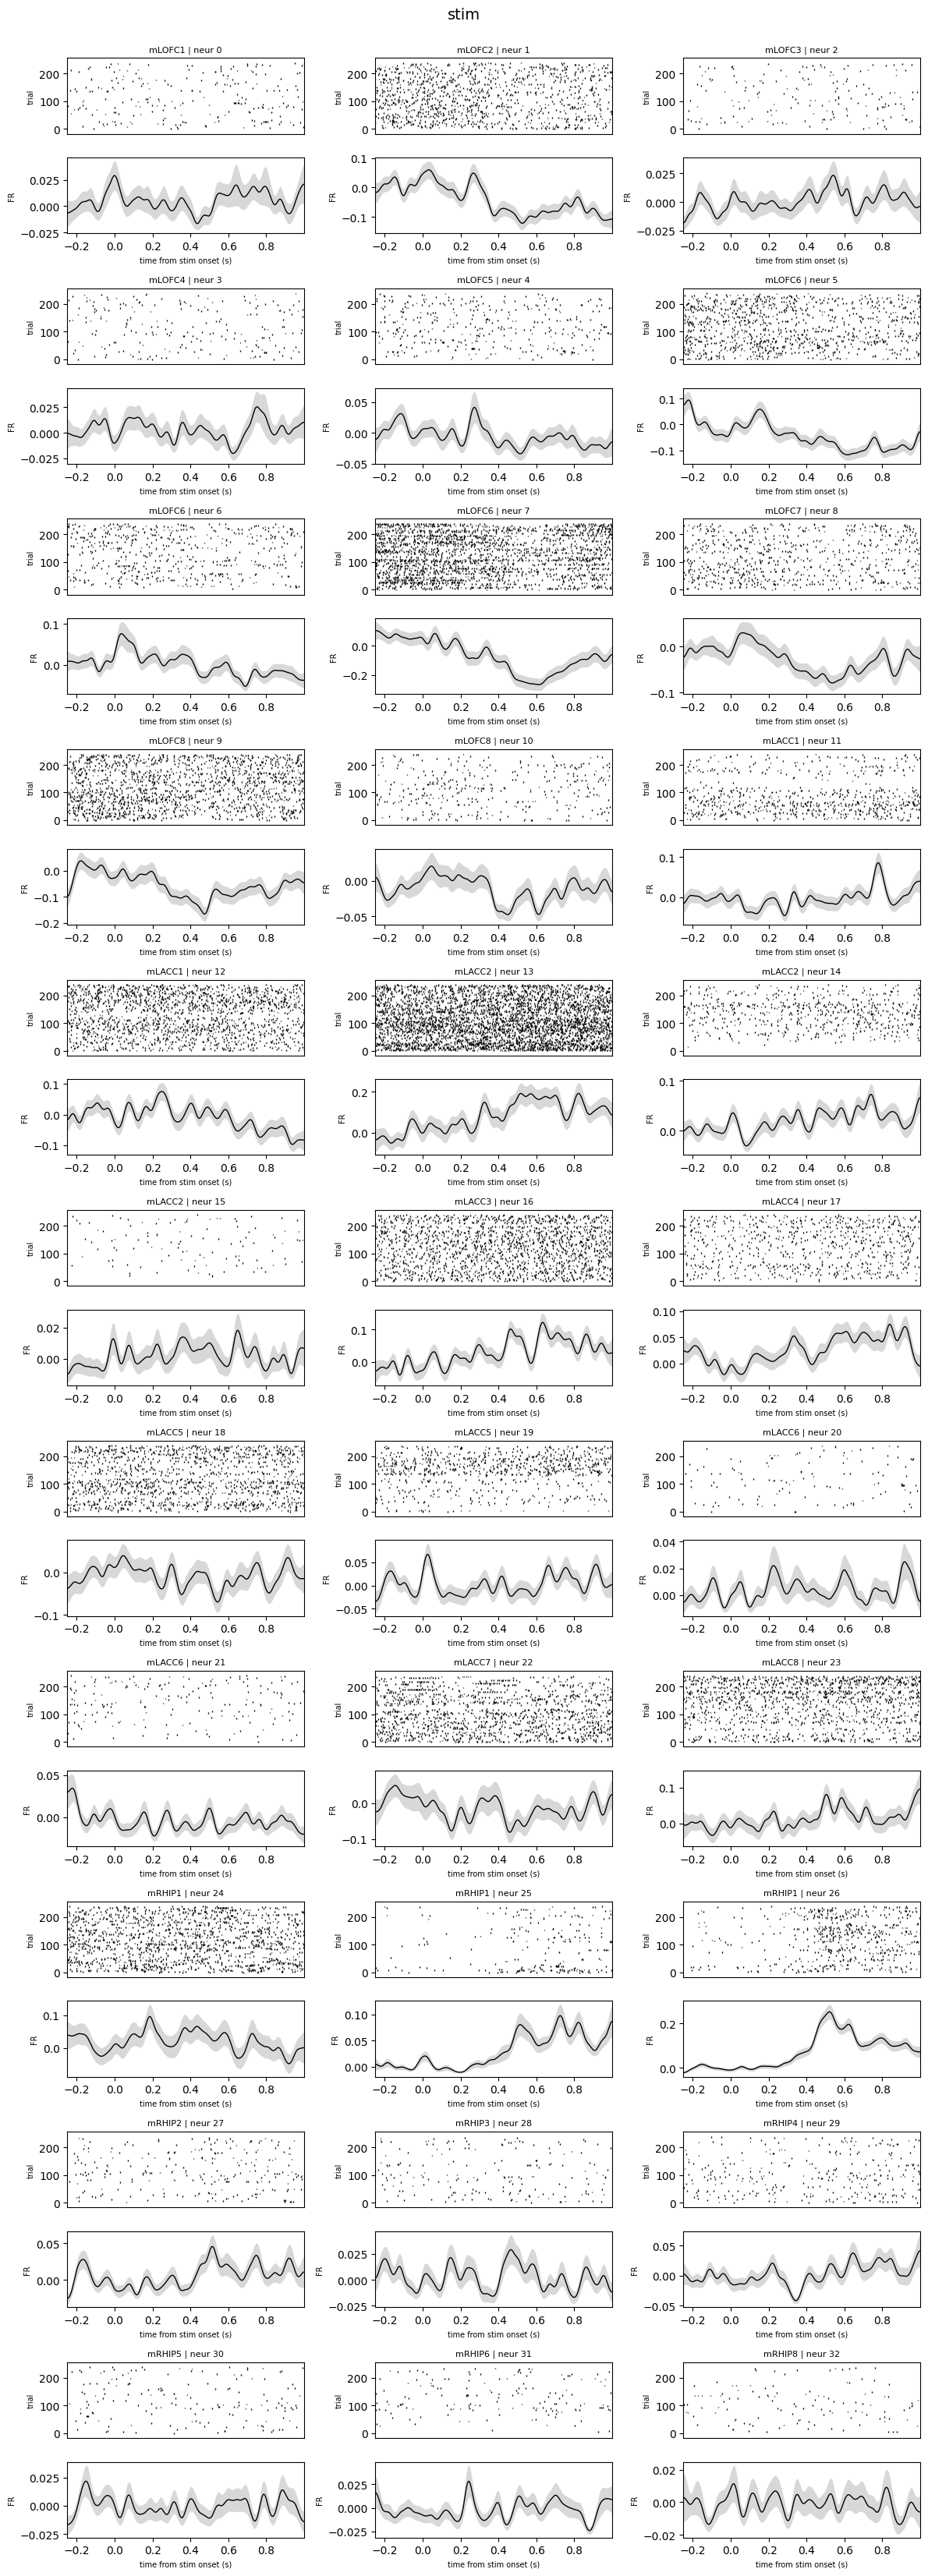

In [19]:
epoch = 'stim'
spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)
normed_FRs = get_normed_FRs(FRs, base_FRs)
n_trials, n_neurs = FRs.shape[0], FRs.shape[1]

# ----- common FR y-axis (use normed for non-baseline, raw for baseline) -----
# FR_all = normed_FRs if epoch != 'baseline' else FRs
# ymin = max(0, np.percentile(FR_all, 1))
# ymax = np.percentile(FR_all, 99)

# ----- grid of neurons -----
n_cols = 3
n_rows = int(np.ceil(n_neurs / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs = axs.flatten()

ax_idx = 0
for neur_id in range(n_neurs):
    if ax_idx >= len(axs):
        break

    # placeholder axes -> we’ll replace with 2 stacked axes
    ax_main = axs[ax_idx]
    ss = ax_main.get_subplotspec()
    ax_main.remove()

    gs = ss.subgridspec(2, 1, height_ratios=[1, 1])
    ax_raster = fig.add_subplot(gs[0])
    ax_psth   = fig.add_subplot(gs[1], sharex=ax_raster)

    # --------- RASTER ---------
    ax_raster.eventplot(
        spikes[:, neur_id],
        colors='k',
        lineoffsets=np.arange(n_trials),
        linelengths=5.0,
        linewidths=1.0
    )
    region = neur_spikes_df["region"].iloc[neur_id]
    ax_raster.set_title(f"{region} | neur {neur_id}", fontsize=8)
    ax_raster.set_ylabel("trial", fontsize=7)
    ax_raster.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # --------- PSTH ---------
    data = normed_FRs[:, neur_id, :] if epoch != 'baseline' else FRs[:, neur_id, :]
    mu = data.mean(axis=0)
    sderr = data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])

    ax_psth.plot(bin_centers, mu, color='k', linewidth=1)
    ax_psth.fill_between(bin_centers, mu - sderr, mu + sderr,
                         color='0.7', alpha=0.5, linewidth=0)

    ax_psth.set_xlim(bin_centers[0], bin_centers[-1])
    ax_psth.set_ylabel("FR", fontsize=7)
    ax_psth.set_xlabel(f"time from {epoch} onset (s)", fontsize=7)

    ax_idx += 1

plt.suptitle(epoch, y=1.0, fontsize=14)
plt.tight_layout()
plt.show()


## create contrasts

In [20]:
def get_contrast_in_epoch(df_trigs, df_spikes, subj_df, epoch, contrast):
    ''' for particular contrast, in a particular epoch, draw out spikes & FRs
        df_trigs: trig times
        df_spikes: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, epoch: {epoch}')

    # get spikes/FRs for all trials/neurons in this epoch
    spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)

    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(df_trigs, df_spikes, 'first_half', size, dt)
    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(df_trigs, df_spikes, 'second_half', size, dt)

    # storing trials and labels for each contrast
    cont_trials, cont_labels = [], []

    # stim contrasts
    if contrast =='context':
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
        cont_labels.append('gain')
        cont_labels.append('loss')
    # elif contrast =='stim':
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
    #     cont_labels.append('flat (curv) stims')
    #     cont_labels.append('curv (flat) stims')
    elif contrast =='uncertainty':
        cont_trials.append(subj_df[~subj_df['uncertainty']].index)
        cont_trials.append(subj_df[subj_df['uncertainty']].index)
        cont_labels.append('certain')
        cont_labels.append('uncertain')

    # choice contrasts (median splits)
    elif contrast == 'resp_dir':
        cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
        cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
        cont_labels.append('right')
        cont_labels.append('left')
    elif contrast == 'normed_RT':
        median_rt = subj_df['normed_RT'].median()
        cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
        cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
        cont_labels.append('fast')
        cont_labels.append('slow')
    # elif contrast == 'dir_flip':
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
    #     cont_labels.append('not flipped')
    #     cont_labels.append('flipped')


    # outcome contrasts
    elif contrast == 'outcome':
        cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
        cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
        cont_labels.append('3 coins')
        cont_labels.append('1 coin')
        cont_labels.append('-1 coin')
        cont_labels.append('-3 coins')

    # condition contrast
    elif contrast == 'conditions':
        cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('gain_expanded')
        cont_labels.append('loss_expanded')
        cont_labels.append('baseline')
    elif contrast == 'baseline vs compressed conditions':
        cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('comp')
        cont_labels.append('base')

    # err
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')

    print('spikes (#trials, #neurs)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
    print('rates (#trials, #neurs, #bins)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

    return spikes, FRs, bin_centers, cont_trials, cont_labels


### contrasted rasters + psth for all neurons

contrast: uncertainty, epoch: delay
#trials should typically be 240/#contrasts
spikes (#trials, #neurs)
	certain: (80, 33)
	uncertain: (160, 33)
rates (#trials, #neurs, #bins)
	certain: (80, 33, 1750)
	uncertain: (160, 33, 1750)


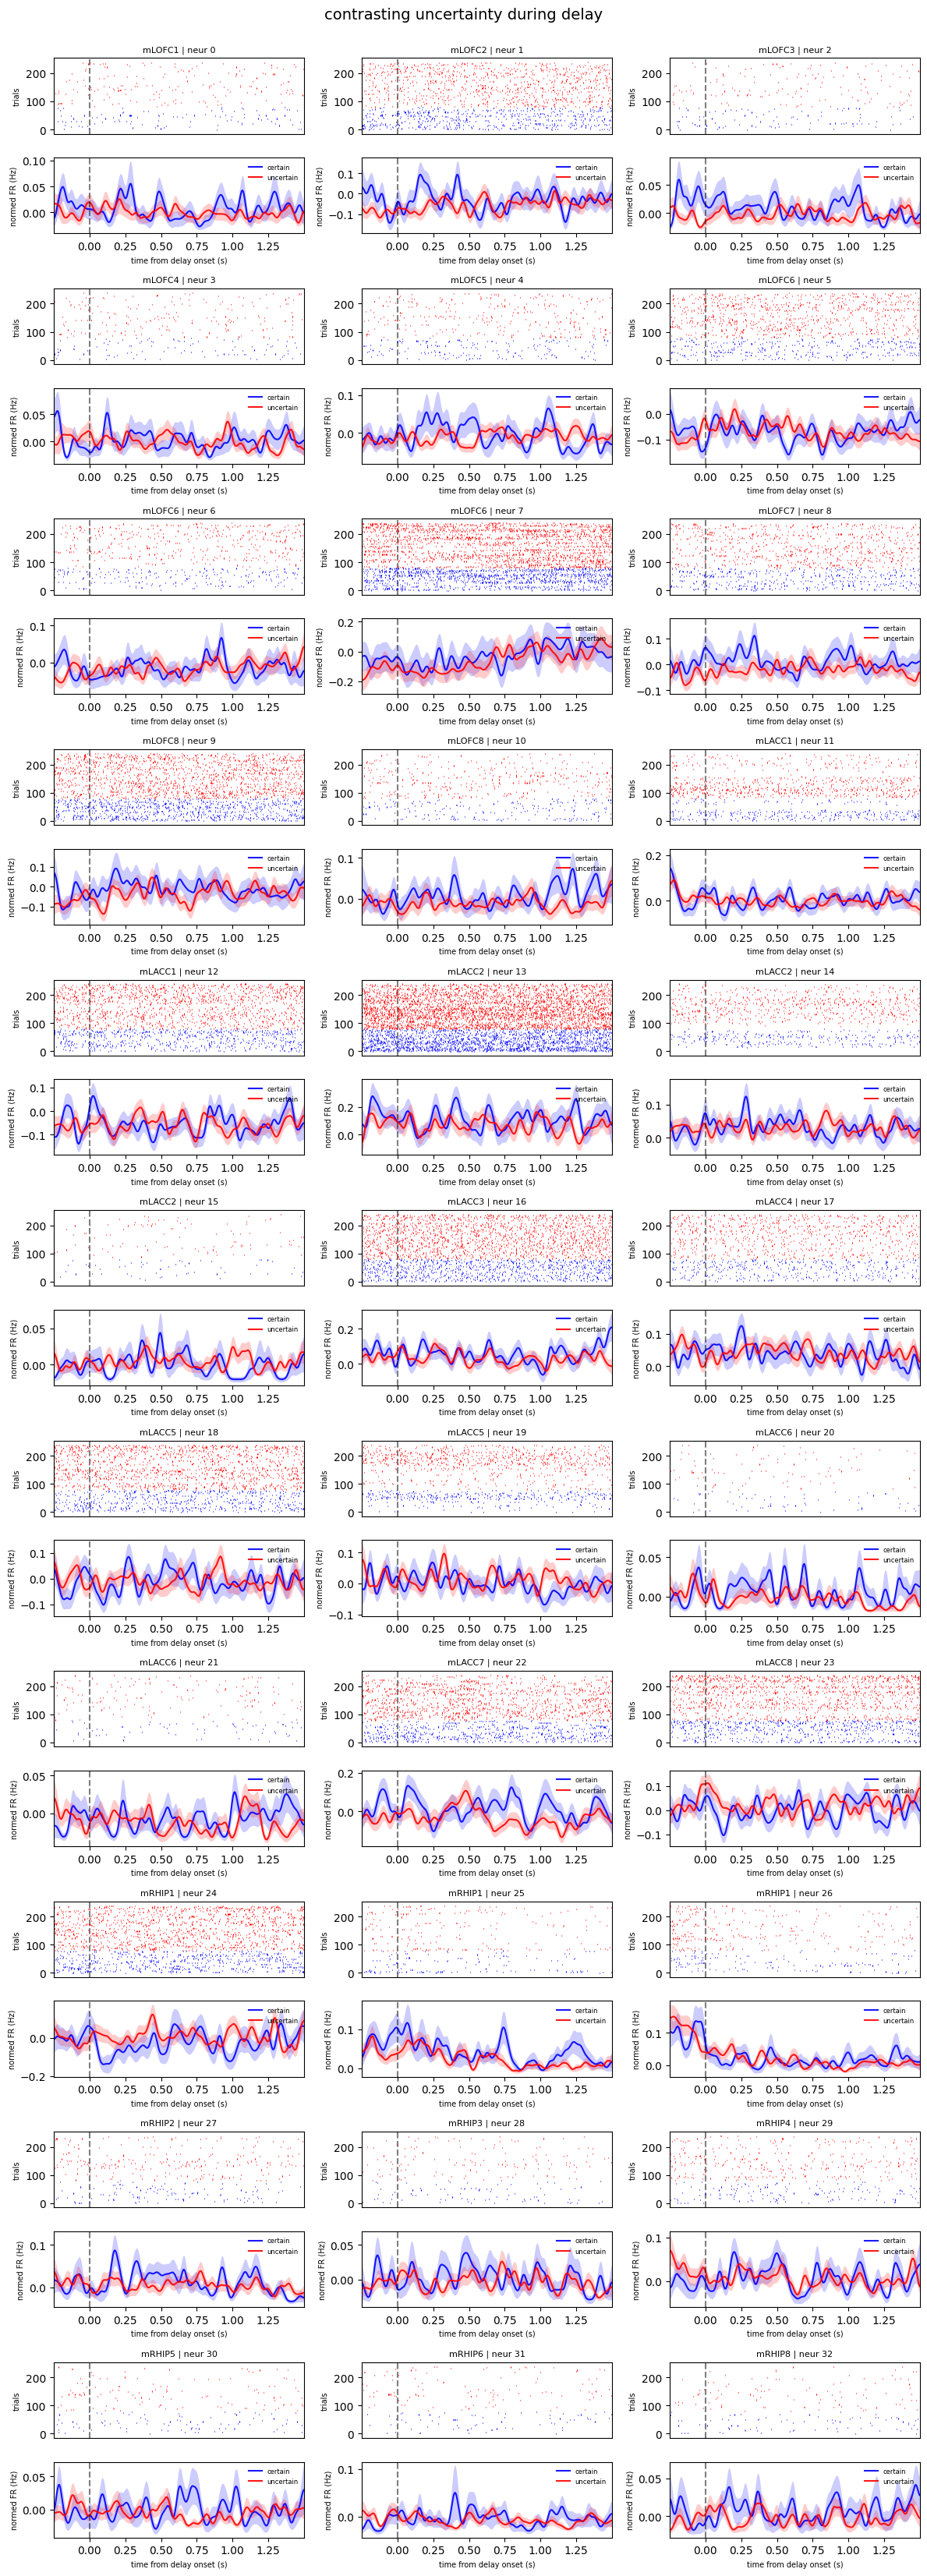

In [30]:
epoch, contrast = 'delay', 'uncertainty'
spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_epoch(
    df_trigs, df_spikes, df_psych, epoch, contrast
)
normed_FRs = get_normed_FRs(FRs, base_FRs)

n_trials, n_neurs, _ = FRs.shape
colors = ['b', 'r', 'g', 'k']  # assume len(cont_labels) <= 4

# ---- grid of neurons ----
n_cols = 3
n_rows = int(np.ceil(n_neurs / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs = axs.flatten()

ax_idx = 0
for neur_id in range(n_neurs):
    if ax_idx >= len(axs):
        break

    # take the placeholder axis for this neuron, then replace with 2 stacked axes
    ax_main = axs[ax_idx]
    ss = ax_main.get_subplotspec()
    ax_main.remove()

    gs = ss.subgridspec(2, 1, height_ratios=[1, 1])
    ax_raster = fig.add_subplot(gs[0])
    ax_psth   = fig.add_subplot(gs[1], sharex=ax_raster)

    # -----------------
    # 1. RASTER (top)
    # -----------------
    raster_trial_list, color_trial_list = [], []

    for idx in range(len(cont_labels)):
        cont_label = cont_labels[idx]
        trial_idx_list = cont_trials[idx]
        cont_color = colors[idx]

        # spikes[trial_idx_list, neur_id] is an array of per-trial spike arrays
        raster_trial_list.extend(list(spikes[trial_idx_list, neur_id]))
        color_trial_list.extend([cont_color] * len(trial_idx_list))

    ax_raster.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax_raster.eventplot(raster_trial_list,orientation='horizontal',colors=color_trial_list,linewidths=0.8,linelengths=3.0,)

    region = neur_spikes_df["region"].iloc[neur_id]
    ax_raster.set_title(f"{region} | neur {neur_id}", fontsize=8)
    ax_raster.set_ylabel("trials", fontsize=7)
    ax_raster.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # -----------------
    # 2. PSTH (bottom)
    # -----------------
    for idx in range(len(cont_labels)):
    # for this contrast

        cont_label = cont_labels[idx]
        cont_color = colors[idx]
        cont_data = normed_FRs[cont_trials[idx], neur_id, :]
        
        # for plotting
        mu = cont_data.mean(axis=0)
        sderr = (cont_data.std(axis=0, ddof=1) / np.sqrt(cont_data.shape[0])
                 if cont_data.shape[0] > 1 else np.zeros_like(mu))
        ax_psth.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
        ax_psth.fill_between(bin_centers, mu - sderr, mu + sderr,
                             color=cont_color, alpha=0.2, linewidth=0)

    ax_psth.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax_psth.set_xlim(bin_centers[0], bin_centers[-1])
    ax_psth.set_ylabel("normed FR (Hz)", fontsize=7)
    ax_psth.set_xlabel(f"time from {epoch} onset (s)", fontsize=7)

    # small legend per neuron (optional — you can drop this if too cluttered)
    ax_psth.legend(loc='upper right', fontsize=6, frameon=False)

    ax_idx += 1

plt.suptitle(f"contrasting {contrast} during {epoch}", y=1.0, fontsize=14)
plt.tight_layout()
plt.show()


### single neuron

In [23]:
# # get unique rowID where region = 'mLACC5'. there might be multiple
# reg = 'mLACC5'
# neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]

# # 1. raster
# plt.figure(figsize=(4,3))
# plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')

# # 1. raster
# # create list of trials by contrast and corresponding color
# raster_trial_list, color_trial_list = [], []
# # for indx in range(len(cont_labels)):
# for indx in [1,0]:
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
#     raster_trial_list.extend(list(spikes[cont_trial, neur_id]))
#     color_trial_list.extend([cont_color] * len(cont_trial))

# plt.axvline(0, color='k', linestyle='--', alpha=0.5)
# plt.eventplot(raster_trial_list, orientation='horizontal', colors=color_trial_list, linewidths=1.0, linelengths=3.0)
# plt.ylabel('sorted trials')
# plt.xlabel(f'time from\n{phase} onset (s)')
# plt.xlim([phase_prestarts[phase], phase_ends[phase]])
# plt.show()

# # 2. psth
# plt.figure(figsize=(4,3))

# for indx in range(len(cont_labels)):
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

#     data = normed_FRs[cont_trial, neur_id, :]
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     plt.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
#     plt.axvline(0, color='k', linestyle='--', alpha=0.5)
#     plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

# plt.ylabel('normed FR (Hz)')
# plt.xlabel(f'time from\n{phase} onset (s)')
# plt.xlim([phase_prestarts[phase], phase_ends[phase]])
# plt.ylim([.25, 1.75])
# plt.legend(handles=[plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
#                     for idx in range(len(cont_labels))], loc='upper right')
# plt.show()


### rasters & psth separately

epoch rasters

In [24]:
# epoch = 'baseline'
# spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = int(np.ceil(n_neurs/3)), 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
# axs, ax = axs.flatten(), 0

# for neur_id in range(n_neurs):
#     axs[ax].eventplot(spikes[:, neur_id], orientation='horizontal', colors='k', alpha=0.3, linewidths=1., linelengths=3.)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron, id={neur_id}',
#                 ylabel='trial', xlabel=f'time from {epoch} onset (s)', xlim=[epoch_prestarts[epoch], epoch_durs[epoch]])
#     ax += 1

# plt.suptitle(epoch, y=1.0, fontsize=16)
# plt.tight_layout()
# plt.show()


epoch psth

In [25]:
# epoch = 'baseline'
# spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = int(np.ceil(n_neurs/3)), 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
# axs, ax = axs.flatten(), 0

# for neur_i in range(n_neurs):

#     # no norming for baseline itself; otherwise norm by trial-baseline
#     data = normed_FRs[:, neur_i, :] if epoch!='baseline' else FRs[:, neur_i, :]
    
#     # grab trial-mean and sderr
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     axs[ax].plot(bin_centers, mu, alpha=0.9)
#     axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
    
#     # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {epoch} onset (s)',
#                 xticks=np.linspace(epoch_prestarts[epoch], epoch_durs[epoch], 6), xlim=[epoch_prestarts[epoch], epoch_durs[epoch]])
#     if epoch!='baseline': axs[ax].set(ylim=[0, 2])
#     ax += 1

# plt.suptitle(epoch, y=1.0, fontsize=16)
# plt.tight_layout()
# plt.show()


contrast psth

In [33]:
# # epochs = ['baseline', 'stim', 'task', 'delay', 'feedback']
# # contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
# epoch, contrast = 'stim', 'context'
# spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_epoch(df_trigs, df_spikes, df_psych, epoch, contrast)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = int(np.ceil(n_neurs / 3)), 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))
# axs, ax = axs.flatten(), 0
# colors = ['b', 'r', 'g', 'k']

# for neur_id in range(n_neurs):

#     for idx in range(len(cont_labels)):

#         cont_label, cont_trial, cont_color = cont_labels[idx], cont_trials[idx], colors[idx]

#         data = normed_FRs[cont_trial, neur_id, :]

#         mu = data.mean(axis=0)
#         sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#         axs[ax].plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
#         axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

#     # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {epoch} onset (s)',
#                 xticks=np.linspace(epoch_prestarts[epoch], epoch_durs[epoch], 6), xlim=[epoch_prestarts[epoch], epoch_durs[epoch]])#, ylim=[0, 2])
#     axs[ax].legend(loc='upper right')
#     ax += 1

# plt.suptitle(epoch, y=1.01, fontsize=16)
# plt.tight_layout()
# plt.show()


### for purposes of plotting entire trial (not divided into epochs), but split into onset-aligned and outcome-aligned

In [26]:
# def get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast):
#     ''' for particular contrast, in a particular phase, draw out spikes & FRs
#         clean_trigs_df: trig times
#         final_neur_df: spike times
#         subj_df: trial info '''
    
#     print(f'contrast: {contrast}, trial_half: {trial_half}')

#     # get spikes/FRs for all trials/neurons in this trial_half
#     spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, trial_half, size, dt)

#     # storing trials and labels for each contrast
#     cont_trials, cont_labels = [], []

#     # stim contrasts
#     if contrast =='context':
#         cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
#         cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
#         cont_labels.append('gain')
#         cont_labels.append('loss')
#     # elif contrast =='stim':
#     #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
#     #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
#     #     cont_labels.append('flat (curv) stims')
#     #     cont_labels.append('curv (flat) stims')
#     elif contrast =='difficulty':
#         cont_trials.append(subj_df[~subj_df['difficulty']].index)
#         cont_trials.append(subj_df[subj_df['difficulty']].index)
#         cont_labels.append('easy')
#         cont_labels.append('hard')

#     # choice contrasts (median splits)
#     elif contrast == 'resp_dir':
#         cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
#         cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
#         cont_labels.append('right')
#         cont_labels.append('left')
#     elif contrast == 'normed_RT':
#         median_rt = subj_df['normed_RT'].median()
#         cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
#         cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
#         cont_labels.append('fast')
#         cont_labels.append('slow')
#     # elif contrast == 'dir_flip':
#     #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
#     #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
#     #     cont_labels.append('not flipped')
#     #     cont_labels.append('flipped')


#     # outcome contrasts
#     elif contrast == 'outcome':
#         cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
#         cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
#         cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
#         cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
#         cont_labels.append('3 coins')
#         cont_labels.append('1 coin')
#         cont_labels.append('-1 coin')
#         cont_labels.append('-3 coins')

#     # condition contrast
#     elif contrast == 'conditions':
#         cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
#         cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
#         cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
#         cont_labels.append('gain_expanded')
#         cont_labels.append('loss_expanded')
#         cont_labels.append('baseline')
#     elif contrast == 'baseline vs compressed conditions':
#         cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
#         cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
#         cont_labels.append('comp')
#         cont_labels.append('base')

#     # err
#     else:
#         raise ValueError('Invalid contrast')

#     print('#trials should typically be 240/#contrasts')

#     print('spikes (#trials, #neurs)')
#     for contrast_idx in range(len(cont_labels)):
#         print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
#     print('rates (#trials, #neurs, #bins)')
#     for contrast_idx in range(len(cont_labels)):
#         print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

#     return spikes, FRs, bin_centers, cont_trials, cont_labels


In [27]:
# # phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# # contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
# trial_half, contrast = '2nd', 'context'
# spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

In [28]:
# # get unique rowID where region = 'mLACC5'. there might be multiple
# reg = 'mLACC5'
# neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]
# colors = ['b', 'r', 'g', 'k']

# # create figure with two subplots (stacked vertically)
# width = 10 if trial_half == '1st' else 6
# fig, axs = plt.subplots(2, 1, figsize=(width, 6), sharex=True,
#                         gridspec_kw={'height_ratios': [1, 1]})  # equal height

# # ---------------------------------------------
# # 1. RASTER
# # ---------------------------------------------
# # --- Raster as dots instead of lines ---
# ax = axs[0]

# trial_counter = 0
# for indx in [1, 0]:
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
    
#     for t_i, trial_idx in enumerate(cont_trial):
#         spike_times = spikes[trial_idx, neur_id]
#         ax.scatter(spike_times, 
#                    np.ones_like(spike_times)*trial_counter, 
#                    s=4, color=cont_color, alpha=.8)  # s = marker size
#         trial_counter += 1

# ax.axvline(0, color='k', linestyle='--', alpha=0.5)
# ax.set_ylabel('sorted trials')
# if trial_half == '1st': ax.set_title('Aligned to stimulus')
# elif trial_half == '2nd': ax.set_title('Aligned to outcome')

# # ---------------------------------------------
# # 2. PSTH
# # ---------------------------------------------
# ax = axs[1]
# for indx in range(len(cont_labels)):
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

#     data = normed_FRs[cont_trial, neur_id, :]
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     ax.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
#     ax.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

# ax.axvline(0, color='k', linestyle='--', alpha=0.5)
# ax.set_ylabel('normed FR (Hz)')
# ax.set_ylim([0, 1.75])

# # ax.set_xlabel(f'time from {phase} onset (s)')
# if trial_half == '1st':
#     ax.set_xlim([-.25, 3.5])
#     for ax in axs:
#         ax.axvline(1, color='k', linestyle='--', alpha=0.5) # end of response
#         ax.axvline(2.5, color='k', linestyle='--', alpha=0.5) # end of response
# elif trial_half == '2nd':
#     ax.set_xlim([-1.25, 1])
#     for ax in axs:
#         ax.axvline(-.25, color='k', linestyle='--', alpha=0.5) # end of response

# # legend
# handles = [plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
#             for idx in range(len(cont_labels))]
# ax.legend(handles=handles, loc='lower right')

# for ax in axs:
#     ax.tick_params(direction='in', length=4, width=1)
# for ax in axs:
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.show()
# # fig.savefig('../../results/figs/sfn/fig4a_real_neur.eps', format='eps', dpi=300)
# plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
# fig.savefig(f'../../results/figs/sfn/fig4a_trial_{trial_half}_half.svg', format='svg', dpi=300)



zifest

In [29]:
# plt.rcParams.update({
#     "axes.titlesize": 20,   # subplot titles
#     "axes.labelsize": 18,   # x/y labels
#     "xtick.labelsize": 16,  # x ticks
#     "ytick.labelsize": 16,  # y ticks
#     "legend.title_fontsize": 16,  # legend title
#     "legend.fontsize": 16,        # legend labels
# })